# Client Churn Using Tree-Based Models

#### Table of Content

1. Project Summary
2. Data Source
3. Load Libraries & Data
4. Feature Engineering
5. Decision Tree Classifier
6. Random Forest Classifier
7. AdaBoost & XGBoost Classifiers
8. Business Value Add

#### Project Summary

Start Summary here.

#### Data Source

The following client churn data feeds various classification models that utilize tree-methods (decision trees, random forests, and gradient boosted trees).  Toward the end of the notebook, there is a comparison in performance metrics across these models.

https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers


* churn.csv: Client churn data for bank customers. Contains variables:

    * CustomerId: contains random values and has no effect on customer leaving the bank
    * Surname: the surname of a customer has no impact on their decision to leave the bank.
    * CreditScore: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
    * Geography: a customer’s location can affect their decision to leave the bank.
    * Gender: it’s interesting to explore whether gender plays a role in a customer leaving the bank.
    * Age: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
    * Tenure: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
    * Balance: also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
    * NumOfProducts: refers to the number of products that a customer has purchased through the bank.
    * IsActiveMember: active customers are less likely to leave the bank.
    * EstimatedSalary: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
    * Exited: whether or not the customer left the bank.

**The goal is to  create a model that predicts whether a client will churn based their attributes.**

#### Load Libraries & Data

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay

In [83]:
df = pd.read_csv('/Users/colefairbanks/GitHub/trees-clientchurn-banks/churn.csv')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Feature Engineering

Recall the purpose is to create a model for future use, so data points missing crucial information won't help in this task, especially since for future data points we will assume the research will grab the relevant feature information.

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [85]:
df['Email'] = df['Surname'].str.lower() + '@gmail.com'

In [86]:
email_dict = df[['CustomerId', 'Email']].set_index('CustomerId')['Email'].to_dict()
surname_dict = df[['CustomerId', 'Surname']].set_index('CustomerId')['Surname'].to_dict()

In [87]:
df = df.set_index('CustomerId')

In [88]:
df.drop(['Surname', 'Email'], axis=1, inplace=True)

In [90]:
df = pd.get_dummies(df, drop_first=True)

In [91]:
df[['Geography_Germany', 'Geography_Spain', 'Gender_Male']] = df[['Geography_Germany', 'Geography_Spain', 'Gender_Male']].astype(int)						

In [92]:
df = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'
         , 'Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Exited']]

In [93]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Exited
CustomerId,,,,,,,,,,,,
15634602,619,42,2,0.00,1,1,1,101348.88,0,0,0,1
15647311,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0
15619304,502,42,8,159660.80,3,1,0,113931.57,0,0,0,1
15701354,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
15737888,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0


## Visualization

sns.scatterplot(x='CreditScore',y='Age',data=df,hue='Exited',palette='Dark2')

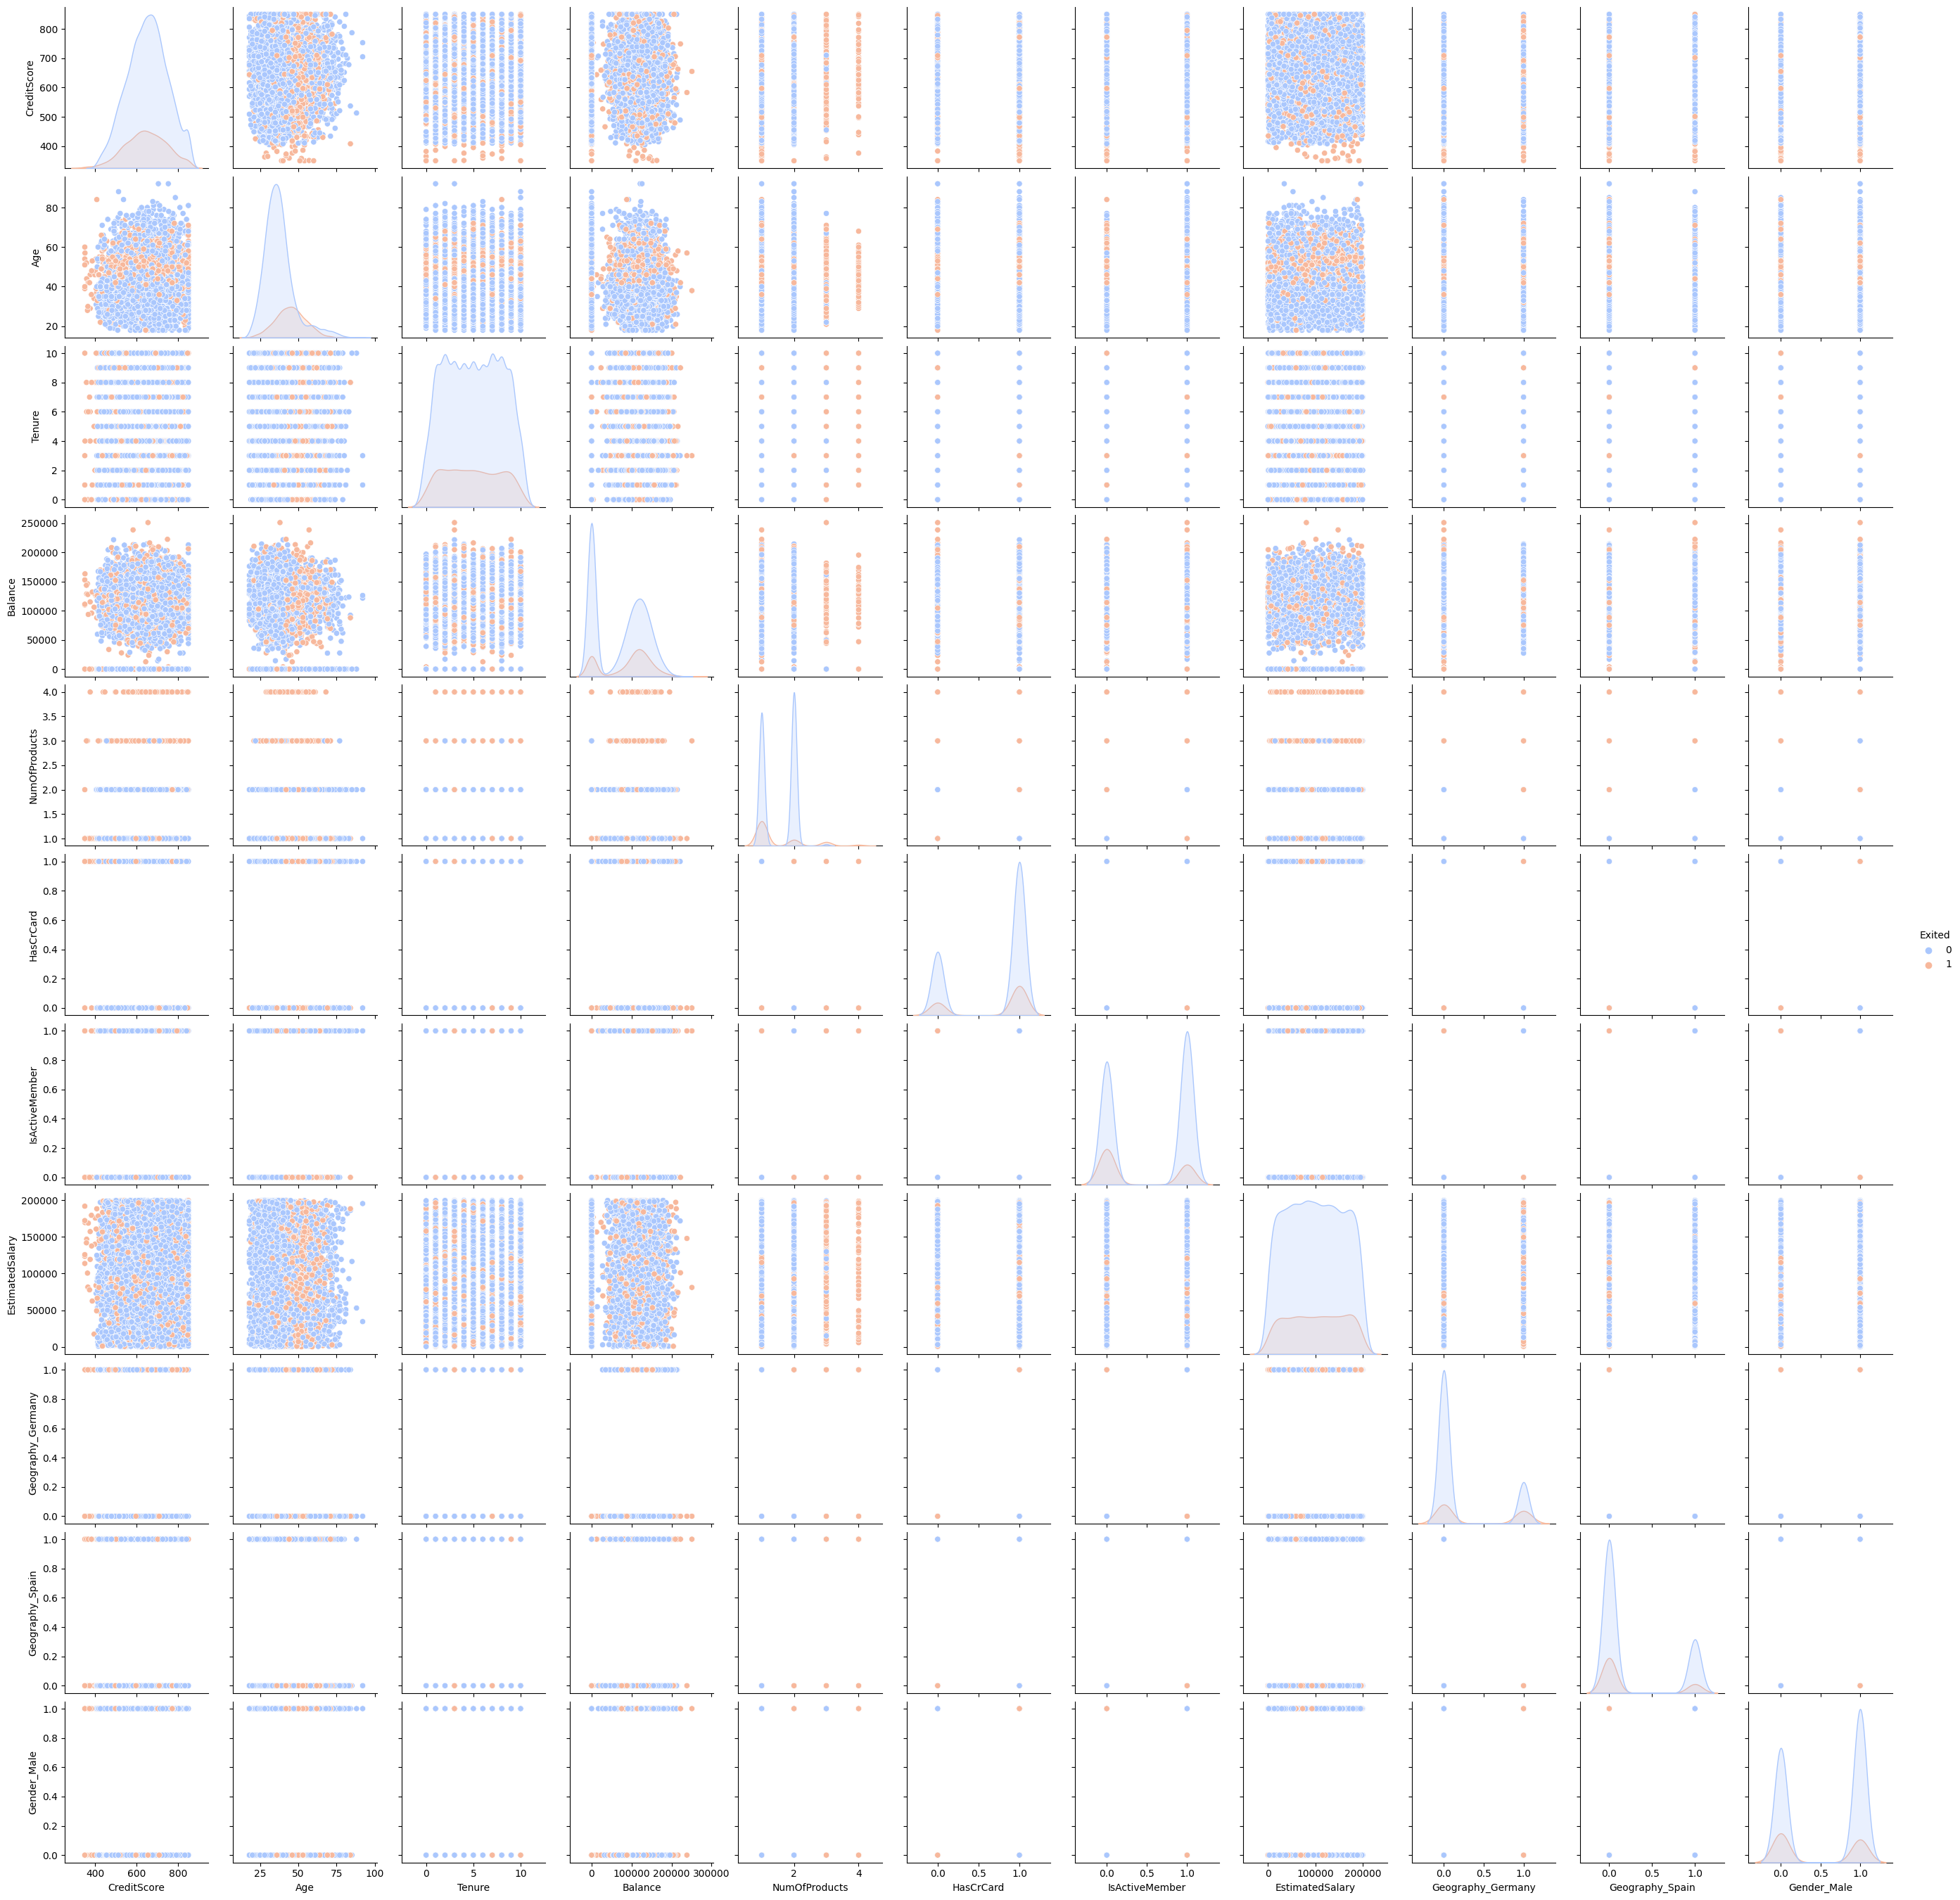

In [94]:
sns.pairplot(df,hue='Exited',palette='coolwarm')

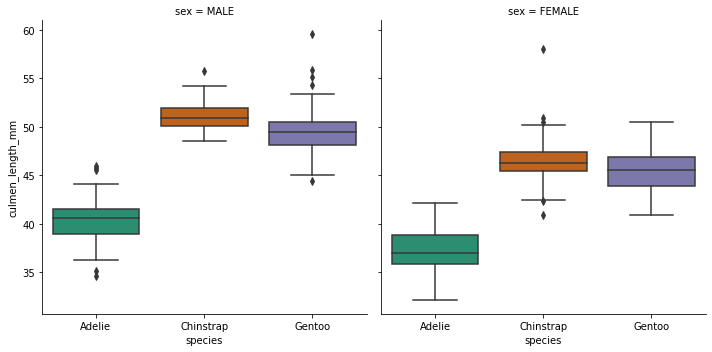

In [127]:
sns.catplot(x='species',y='culmen_length_mm',data=df,kind='box',col='sex',palette='Dark2')

## Train | Test Split

As a first step, the feature columns need to be separated from the target, "Exited."

In [106]:
X = df.iloc[:, :-1]
y = df['Exited']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Decision Tree Classifier

## Default Hyperparameters

In [110]:
model = DecisionTreeClassifier()

In [111]:
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [116]:
base_pred = model.predict(X_test)

## Evaluation

In [117]:
confusion_matrix(y_test,base_pred)

array([[2069,  309],
       [ 279,  343]])

In [121]:
#ConfusionMatrixDisplay(model,X_test,y_test)

In [122]:
print(classification_report(y_test,base_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2378
           1       0.53      0.55      0.54       622

    accuracy                           0.80      3000
   macro avg       0.70      0.71      0.71      3000
weighted avg       0.81      0.80      0.81      3000



In [123]:
model.feature_importances_

array([0.14367925, 0.23539791, 0.06519389, 0.14320329, 0.11682102,
       0.01786215, 0.05347089, 0.17027131, 0.02419813, 0.00761465,
       0.02228751])

In [124]:
pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=['Feature Importance'])

,Feature Importance
CreditScore,0.143679
Age,0.235398
Tenure,0.065194
Balance,0.143203
NumOfProducts,0.116821
HasCrCard,0.017862
IsActiveMember,0.053471
EstimatedSalary,0.170271
Geography_Germany,0.024198
Geography_Spain,0.007615


<AxesSubplot:xlabel='species', ylabel='body_mass_g'>

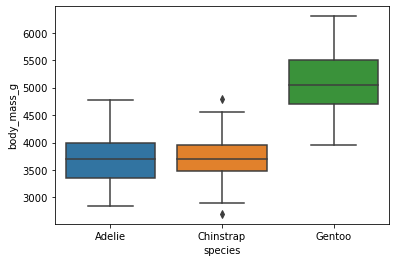

In [180]:
sns.boxplot(x='species',y='body_mass_g',data=df)

## Visualize the Tree

This function is fairly new, you may want to review the online docs:

Online Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

In [145]:
from sklearn.tree import plot_tree

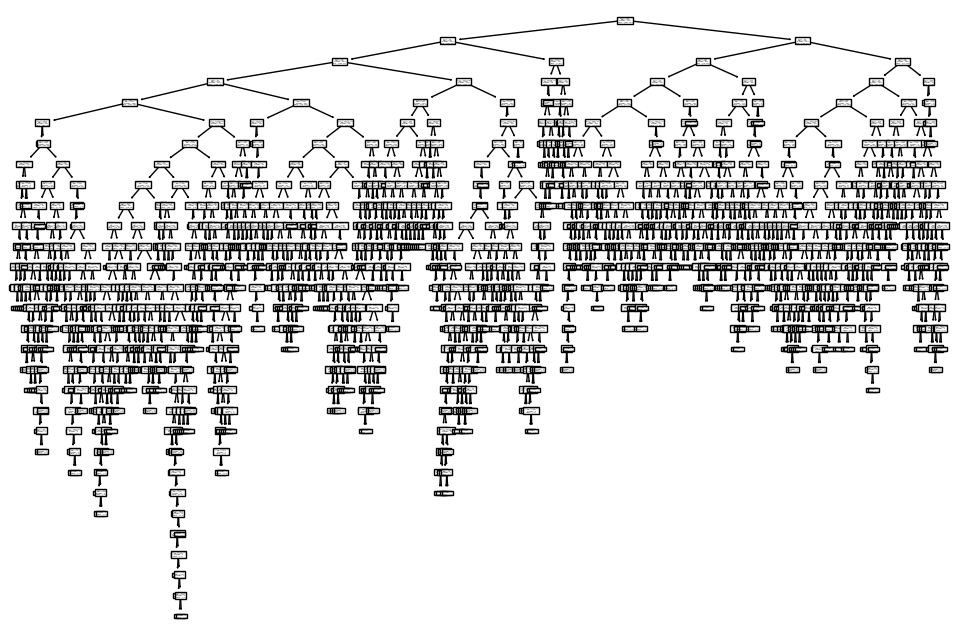

In [128]:
plt.figure(figsize=(12,8))
tree.plot_tree(model);

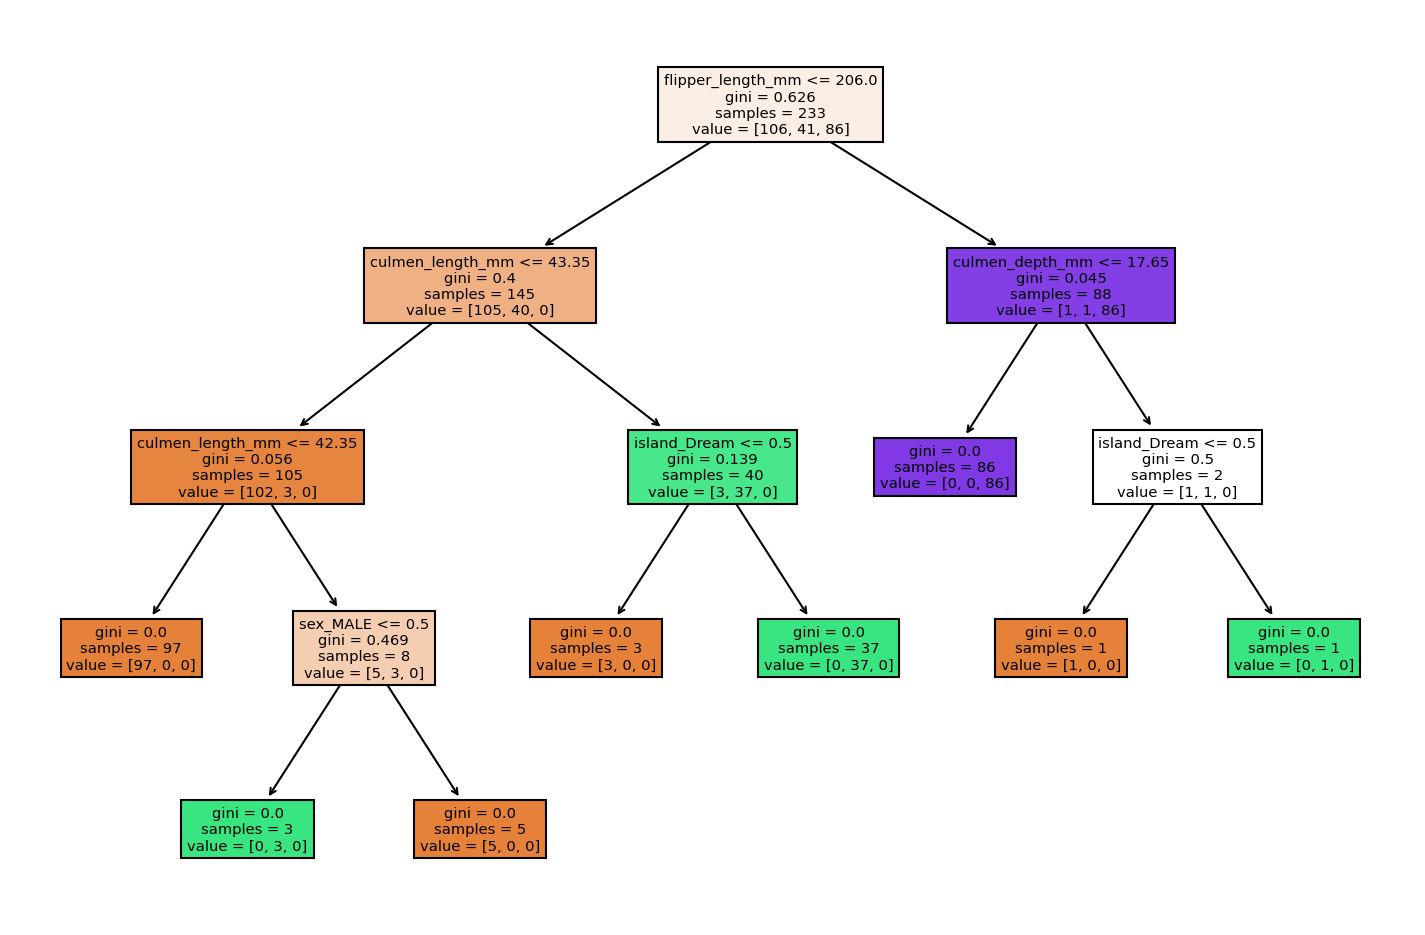

In [166]:
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model,filled=True,feature_names=X.columns);

## Reporting Model Results

To begin experimenting with hyperparameters, let's create a function that reports back classification results and plots out the tree.

In [171]:
def report_model(model):
    model_preds = model.predict(X_test)
    print(classification_report(y_test,model_preds))
    print('\n')
    plt.figure(figsize=(12,8),dpi=150)
    plot_tree(model,filled=True,feature_names=X.columns);

## Understanding Hyperparameters

### Max Depth

In [131]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy", "log_loss"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "log_loss" and "entropy" both for the
 |      Shannon information gain, see :ref:`tree_mathematical_formulation`.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to 

In [129]:
pruned_tree = DecisionTreeClassifier(max_depth=2)
pruned_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [130]:
report_model(pruned_tree)

NameError: name 'report_model' is not defined

## Max Leaf Nodes

In [185]:
pruned_tree = DecisionTreeClassifier(max_leaf_nodes=3)
pruned_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=3)

              precision    recall  f1-score   support

      Adelie       0.95      0.95      0.95        40
   Chinstrap       0.91      0.78      0.84        27
      Gentoo       0.86      0.97      0.91        33

    accuracy                           0.91       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.91      0.91       100





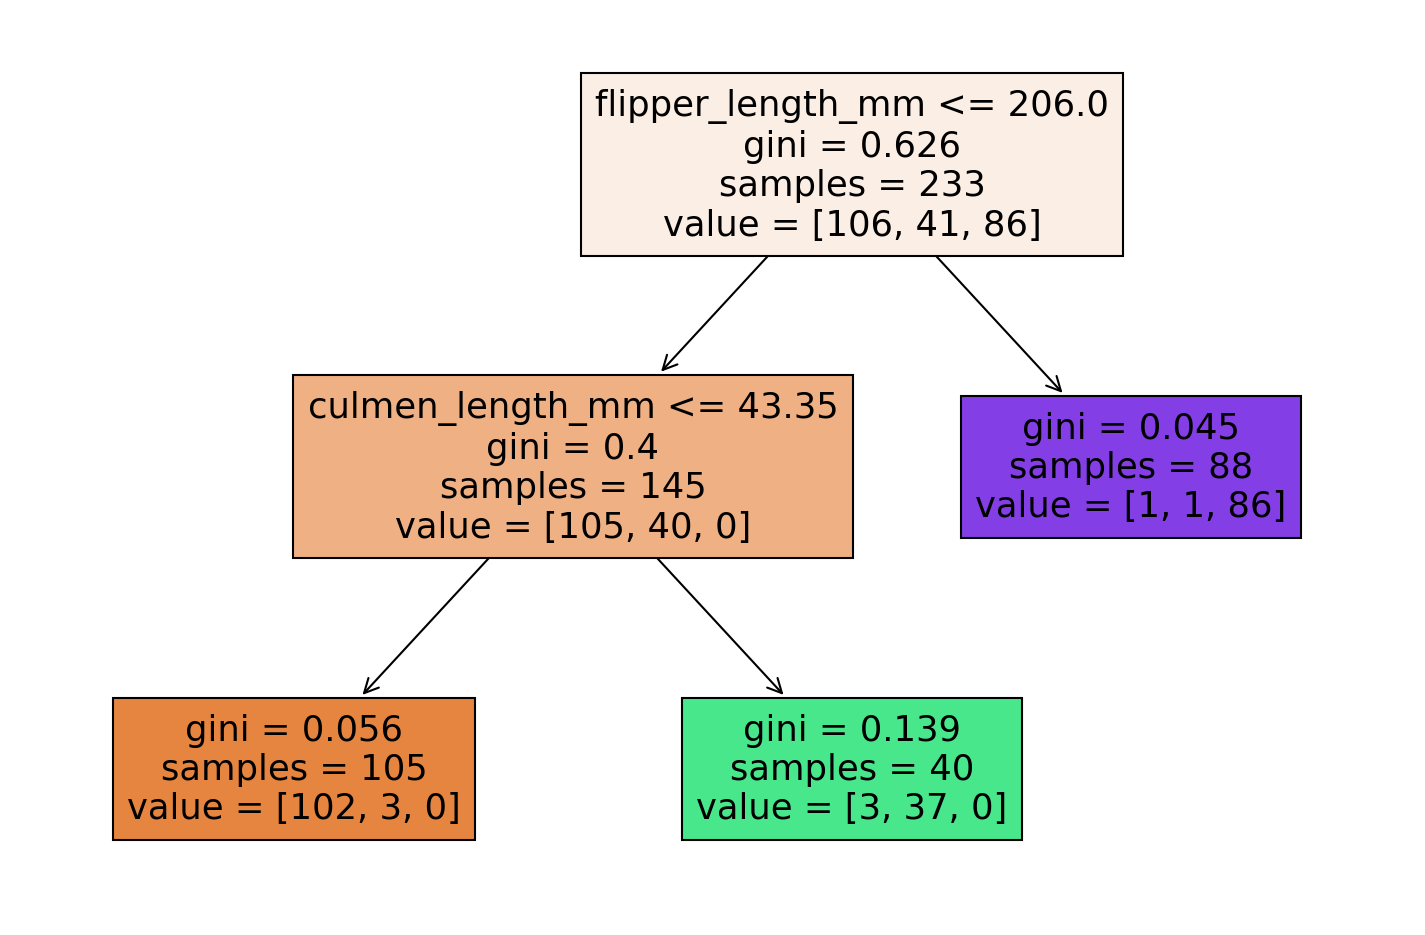

In [186]:
report_model(pruned_tree)

## Criterion

In [187]:
entropy_tree = DecisionTreeClassifier(criterion='entropy')
entropy_tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

              precision    recall  f1-score   support

      Adelie       0.95      0.95      0.95        40
   Chinstrap       0.93      0.96      0.95        27
      Gentoo       1.00      0.97      0.98        33

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100





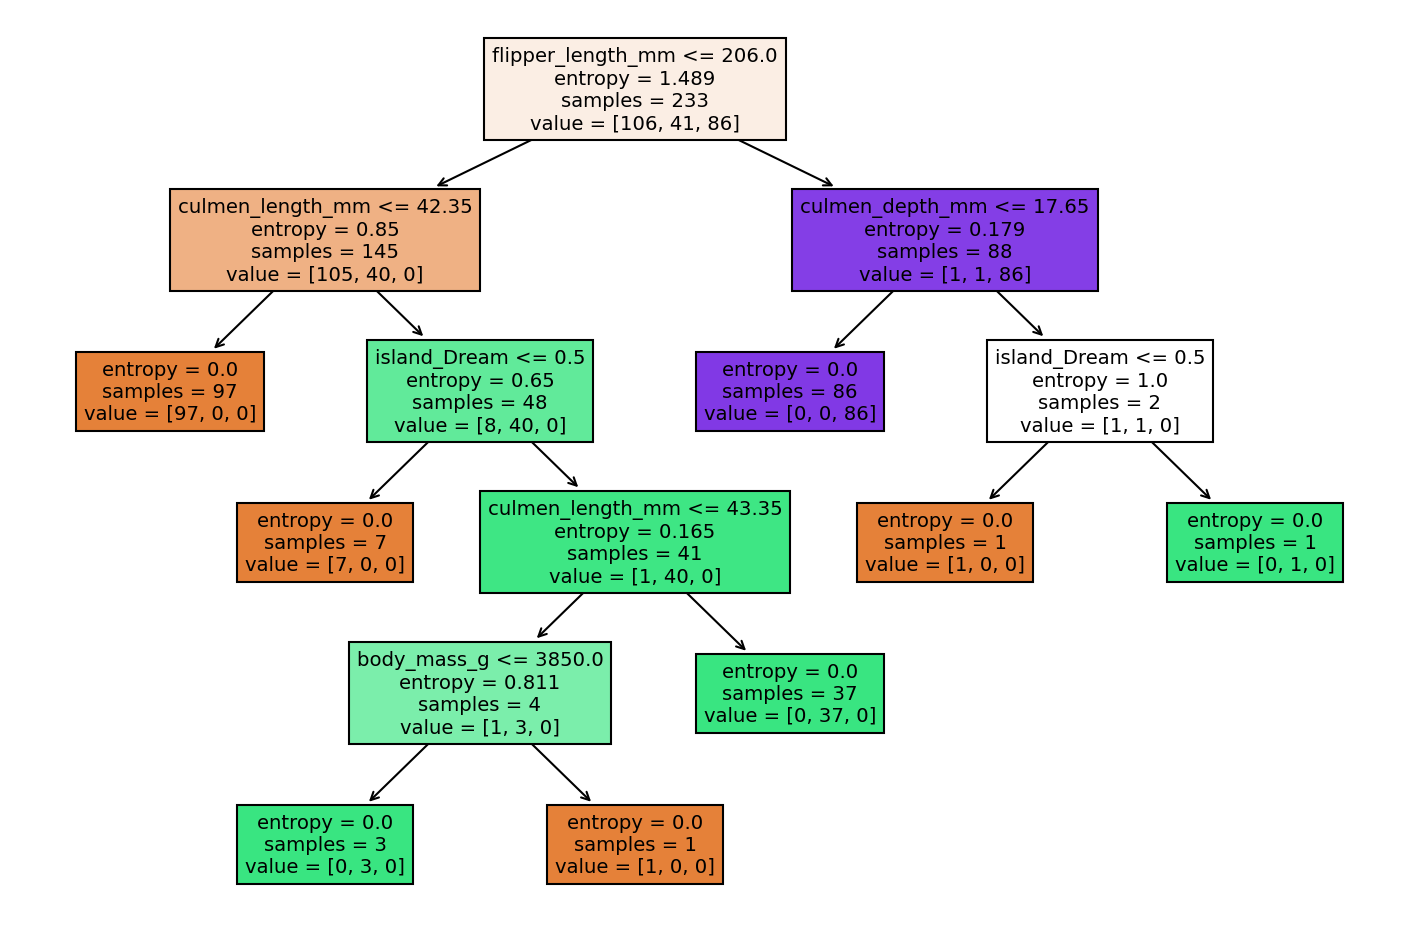

In [188]:
report_model(entropy_tree)

---